Magneto Optical Trap (MOT)

In [1]:
#Import necessary packages
# %matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sympy as sym
import scipy as sp
from scipy import constants as cons
from scipy import stats
from scipy.stats import multivariate_normal
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')
from matplotlib import cm
from matplotlib.ticker import LinearLocator


In [2]:
#Figure Settings 
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
#Rubidium 87 parameters

mass_u = cons.value("atomic mass constant")
mass_rb85 = 84.9118 * mass_u #Kg
mass_rb87 = 86.9091 * mass_u #Kg
mass_na23 = 22.9898 * mass_u #Kg
collision_cs = 2e-17 # (m2) # Collision cross-section for RB atoms

# D2 Line Optical Properties

lifetime_d2rb87 = 2.624e-8 # (ns) Excited state lifetime of Rb87
decay_d2rb87 = (1/lifetime_d2rb87) # (s-1) Natural line width
decay_atomic = decay_d2rb87/(2*np.pi)
atom_frequency_d2rb87 = 384.2304844e12 # Hz (*2*pi for w0)

# D1 Line Optical Properties

lifetime_d1rb87 = 2.770e-8 #excited state lifetime of Rb87 (ns)
decay_d1rb87 = (1/lifetime_d1rb87) / (2*cons.pi) #(s-1) Natural line width
atom_frequency_d1rb87 = 377.1074635e12 # Hz (*2*pi for w0)

In [4]:
#Beam Parameters
detuning =  8e6 *2*cons.pi# (not Hz), rads or 
freq_laser =  atom_frequency_d2rb87 - detuning #Hz - Calculated from a red-shifted detuning
beam_intensity = 10 # (W/m2) Educated guess of a possible beam intensity
wavenumber = (2* cons.pi * freq_laser) / cons.c  #m-1 Wave number of the trapping light k
wavelength = cons.c / freq_laser
beam_radious = 0.01 # metres (2cm diameter beam)
dipole_moment_polarised = 2.534e-29 #(C*m) Dipole moment for F = 2 to F' = 3 transition pol light
beams = 6 # Number of total beams (6 beam MOT)

#Trap Parameters
area = 4*cons.pi*beam_radious**2  # Surface area of overlap volume
volume = (4/3)*cons.pi*beam_radious**3 # Overlap Volume Sphere 
volume_steinmetz = 8 * (2 - np.sqrt(2)) * beam_radious**3
background_temp = 293 # Background temperature (K)
velocity_rms = np.sqrt((2 * cons.k * background_temp)/(mass_rb87)) #Root mean squared velocity background gas (m/s)

#Saturation intensity RB87 D2 Line (W/m2)
sat_intensity = (cons.hbar * (2*cons.pi*atom_frequency_d2rb87)**3 * decay_d2rb87) / (12*cons.pi* cons.c **2)
v_thermal = np.sqrt((8*cons.k * background_temp)/ (cons.pi * mass_rb87))
no_density = 1e8 #/cm3 backfround gas density 
beta = beam_intensity / sat_intensity # Saturation parameter Ii/Isat
mu = cons.value("Bohr magneton") # JOULES PER TESLA J/T

ODE Time-dependent Acceleration Function $ \frac{da}{dt} $


In [5]:
# Time-dependent ODE Function
# Negative Acceleration 
# Parameters: Intensity, Detuning and Magnetic Gradient
def dadt(x, S, beam_intensity, detuning, B):
    x, v = S
    return [v,
           -((cons.hbar * wavenumber * decay_d2rb87 * (beam_intensity / sat_intensity))/(2*mass_rb87) * (((1)/(1 + beams*(beam_intensity / sat_intensity) + 4*((detuning - wavenumber * v - (mu*B*x/cons.hbar))/decay_d2rb87)**2)) - (((1)/(1 + beams*(beam_intensity / sat_intensity) + 4*((detuning + wavenumber * v + (mu*B*x/cons.hbar))/decay_d2rb87)**2)))))]

Function to perform integration on the acceleration MOT equation w/Zeeman Effect

In [6]:
# Numerical Integration Optical Molasses w/ ODE
def ODE(beam_intensity, detuning, B):
    x_0 = 0.01
    v_0 = 0.1
    S_0 = (x_0, v_0)
    t = np.linspace(0.03, 0, 1000)
    t_span=[t[0], t[-1]]
    sol = sp.integrate.solve_ivp(dadt, t_span, S_0, t_eval = t, args=(beam_intensity, detuning, B), method='RK45') # args = (beam_intensity, detuning, B)
    return [sol.y[0,:], sol.y[1,:]]

Function that outputs the capture velocity $v_c$ for a given starting position (beam diameter/edge)

In [7]:
def cap_vel(x_0, beam_intensity, detuning, B):
    v_0 = 0.1
    S_0 = (x_0, v_0)
    t = np.linspace(1, 0, 100000) #was 1 and 0.2 adn 0.03 before
    t_span=[t[0], t[-1]]
    sol = sp.integrate.solve_ivp(dadt, t_span, S_0, t_eval = t, args=(beam_intensity, detuning, B), method='RK23') # args = (beam_intensity, detuning, B)
    f_linear = sp.interpolate.interp1d(sol.y[0,:],sol.y[1,:]) 
    return [f_linear(-x_0), sol]
    #return np.interp(-x_0, sol.y[0,:], sol.y[1,:])

In [8]:
B = 0.1#T/m
# Numerical Integration Optical Molasses 
v = np.linspace(0, 20, 1000)
def dx(vA, detuning, beam_intensity):
    res = lambda vA: vA/((cons.hbar * wavenumber * decay_d2rb87 * 0.5)/(mass_rb87) * (((beam_intensity / sat_intensity)/(1 + beams*(beam_intensity / sat_intensity) + ((2*detuning - 2* wavenumber * vA)/decay_d2rb87)**2)) - (((beam_intensity / sat_intensity)/(1 + beams*(beam_intensity / sat_intensity) + ((2*detuning + 2* wavenumber * vA)/decay_d2rb87)**2)))))
    lit = np.zeros_like(vA)
    for i, val in enumerate(vA):
        y, err = sp.integrate.quad(res, 1, val)
        lit[i] = y
    return lit
result = np.array([])

Capture velocity $v_c$ as beam diameter changes w/ B = 0.1T

In [9]:
beamdiams = np.linspace(0.001, 0.05, 100)
mags = np.linspace(0, 0.2, 10)
res = np.zeros((100, 10))
output_x = np.zeros((1000, 1000))
output_y = np.zeros((1000, 1000))

for i in range(len(mags)):
    for k in range(len(beamdiams)):
        capture_velocity = cap_vel(beamdiams[k], 10, 8e6*2*np.pi, mags[i])
        res[k, i] = capture_velocity[0]
        # output_x[:,k] = capture_velocity[1].y[0,:]
        # output_y[:,k] = capture_velocity[1].y[1,:]


#B = 0 for comparison 
# B0v = np.linspace(0, 20, 1000)
# B0x = dx(B0v, 8e6*2*cons.pi, 10)

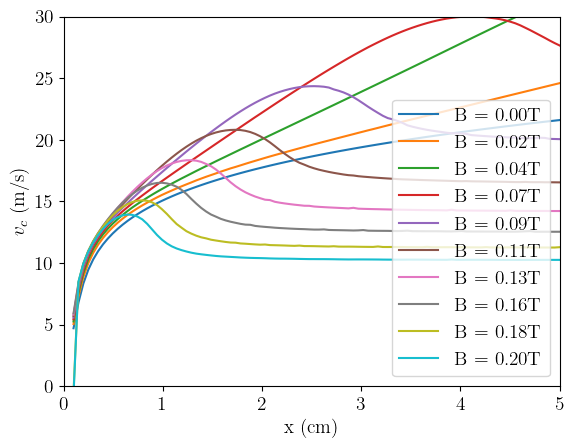

In [10]:
for i in range(10):
    plt.plot(beamdiams*100, res[:,i],label= f'B = {mags[i]:.2f}T')
    plt.xlabel("x (cm)")
    plt.ylabel(r"$v_c$ (m/s)")
plt.ylim(0, 30)
plt.xlim(0, 5)
plt.legend()

C:\Users\Richa\AppData\Local\Temp\ipykernel_14288\2174805605.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(beamdiams*100), np.log(res[:,i]),label= f'B = {mags[i]:.2f}T')


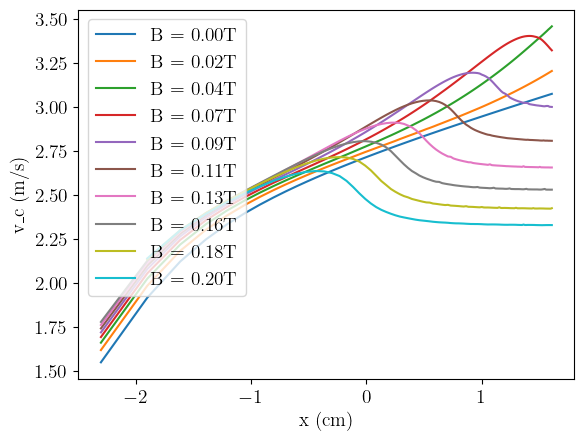

In [11]:
for i in range(10):
    plt.plot(np.log(beamdiams*100), np.log(res[:,i]),label= f'B = {mags[i]:.2f}T')
    plt.xlabel("x (cm)")
    plt.ylabel("v_c (m/s)")
#plt.ylim(0, 30)
#plt.xlim(0, 5)
plt.legend()

Function to calculate the $v_c$ for a given detuning array $\Delta$

In [12]:
#Function to get vc from varying detuning
detunings = np.linspace(0, 100, 200)*1e6 # IN HERTZ
res_detuning = np.zeros((200))

def detuning_func(beam_intensity, detuning, B):
    x_0 = 0.01
    v_0 = 0.1
    S_0 = (x_0, v_0)
    t = np.linspace(.2, 0, 10000)
    t_span=[t[0], t[-1]]
    sol = sp.integrate.solve_ivp(dadt, t_span, S_0, t_eval = t, args=(beam_intensity, detuning*2*cons.pi, B), method='RK23') # args = (beam_intensity, detuning, B)
    f_linear_det = sp.interpolate.interp1d(sol.y[0,:],sol.y[1,:]) 
    return f_linear_det(-x_0)

for i in range(len(detunings)):
    res_detuning[i] = detuning_func(10, detunings[i], 0)

Maximum velocity at detuning of 13.57MHz with 16.94m/s


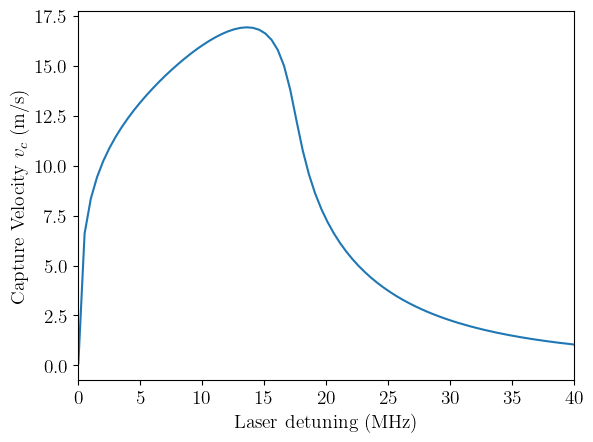

In [13]:
#Plot of Detuning vs Capture velocity
f_linear_detuning_vc = sp.interpolate.interp1d(res_detuning, detunings) 
plt.plot(detunings/1e6, res_detuning)
plt.xlabel(2)
plt.xlabel("Laser detuning (MHz)")
plt.ylabel("Capture Velocity $v_c$ (m/s)")
plt.xlim(0, 40)
max_det = f_linear_detuning_vc(max(res_detuning))/1e6
print(f'Maximum velocity at detuning of {max_det:.2f}MHz with {max(res_detuning):.2f}m/s')

Maximum number of atoms at detuning of 13.57MHz with 1.65*10^8 atoms


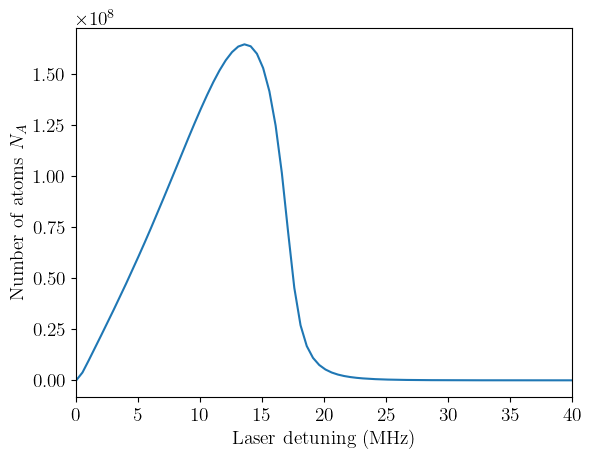

In [14]:
#Plot of Detuning vs Number of Atoms
no_atoms_det = 0.1 * (4*cons.pi*0.01**2/collision_cs) * (res_detuning / velocity_rms)**4
f_linear_detuning_na = sp.interpolate.interp1d(no_atoms_det, detunings) 
plt.plot(detunings/1e6, no_atoms_det)
plt.xlabel(2)
plt.xlabel("Laser detuning (MHz)")
plt.ylabel("Number of atoms $N_A$")
plt.xlim(0, 40)
max_det = f_linear_detuning_na(max(no_atoms_det))/1e6
print(f'Maximum number of atoms at detuning of {max_det:.2f}MHz with {max(no_atoms_det)/1e8:.2f}*10^8 atoms')

In [15]:
# Number of Atoms Trapped w/ dx function (B = 0)
v_no = np.linspace(0, 20, 10000)
x_no = dx(v_no, 8e6*2*cons.pi, 10)
no_atoms = 0.1 * (4*cons.pi*x_no**2/collision_cs) * (v_no / velocity_rms)**4


Text(0, 0.5, 'Number of atoms $N_A$')

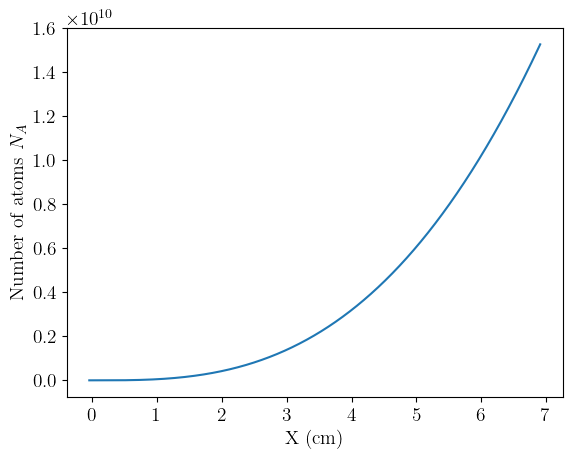

In [16]:
# Capture velocity vs no of atoms 
plt.figure(7)
plt.plot(x_no*100, no_atoms)
plt.xlabel("X (cm)")
plt.ylabel("Number of atoms $N_A$")
#plt.title("Atom velocity V (m/s) vs Number of Atoms")

Number of Atoms $N_A$ as beam diameter changes w/ B = 0.1T

In [17]:
beamdiams = np.linspace(0.001, 0.05, 100)
mags = np.linspace(0, .5, 10)
res = np.zeros((100, 10))
output_x = np.zeros((1000, 1000))
output_y = np.zeros((1000, 1000))

for i in range(len(mags)):
    for k in range(len(beamdiams)):
        capture_velocity = cap_vel(beamdiams[k], 10, 8e6*2*np.pi, mags[i])
        res[k, i] = capture_velocity[0]


#B = 0 for comparison 
B0v = np.linspace(0, 20, 1000)
B0x = dx(B0v, 8e6*2*cons.pi, 10)

Change in $v_c$ as $B$ changes 

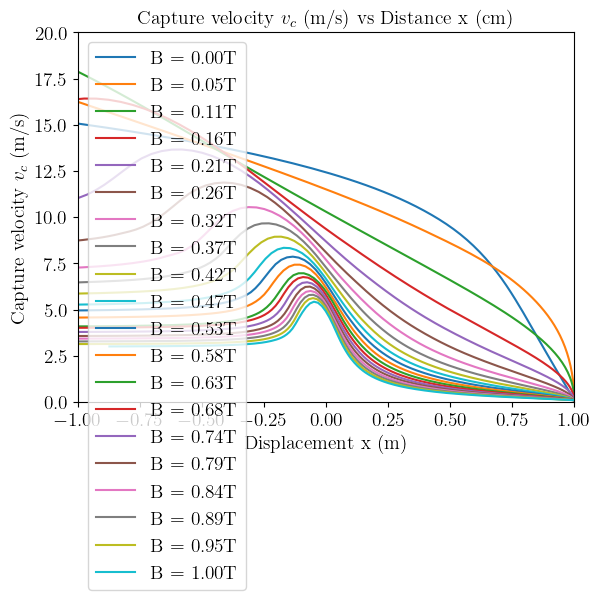

In [18]:
detuning = 2*cons.pi * 8e6
x_0 = 0.01
v_0 = 0.1
S_0 = (x_0, v_0)
t = np.linspace(0.03, 0, 1000)
#t_span = (0, 0.01)
t_span=[t[0], t[-1]]
#B = np.array([0, 0.05, 0.1, 0.15, 0.20, 0.25, 0.5, 1])
B = np.linspace(0, 1, 20)
for i in B:
    #B = i 
    sol = sp.integrate.solve_ivp(dadt, t_span, S_0, t_eval = t, args=(10, detuning, i), method='RK45') # args = (beam_intensity, detuning, B)
    plt.plot(sol.y[0,:]*100,sol.y[1,:],label= f'B = {i:.2f}T')
    # plt.plot(sol.t, sol.y[1,:])
plt.figure(1)
plt.xlim(-1, 1)
plt.ylim(0,20)

plt.ylabel(r"Capture velocity $v_c$ (m/s)")
plt.xlabel("Displacement x (m)")
plt.title(r"Capture velocity $v_c$ (m/s) vs Distance x (cm)")
plt.legend()
plt.show()

Function to find $N_A$ to be optimised 

In [19]:
def N_A(x_0, beam_intensity, detuning, B):
    v_0 = 0.1
    S_0 = (x_0, v_0)
    t = np.linspace(.1, 0, 10000) #was 1 and 0.2 adn 0.03 before
    t_span=[t[0], t[-1]]
    sol = sp.integrate.solve_ivp(dadt, t_span, S_0, t_eval = t, args=(beam_intensity, detuning, B), method='RK23') # args = (beam_intensity, detuning, B)
    f_linear = sp.interpolate.interp1d(sol.y[0,:],sol.y[1,:])
    number_atoms = (4*cons.pi*x_0**2/(8*collision_cs)) * (f_linear(-x_0) / velocity_rms)**4
    return number_atoms
    #return [sol.y[0,:], sol.y[1,:]]

In [20]:
beam_diam = np.linspace(0.001, 0.07, 100)
mags = np.linspace(0, 0.2, 10)
rr = np.zeros((100, 10))
for i in range(len(mags)):
    for k in range(len(beam_diam)):
        no_atoms = N_A(beamdiams[k], 10, 8e6*2*np.pi, mags[i])
        rr[k, i] = no_atoms

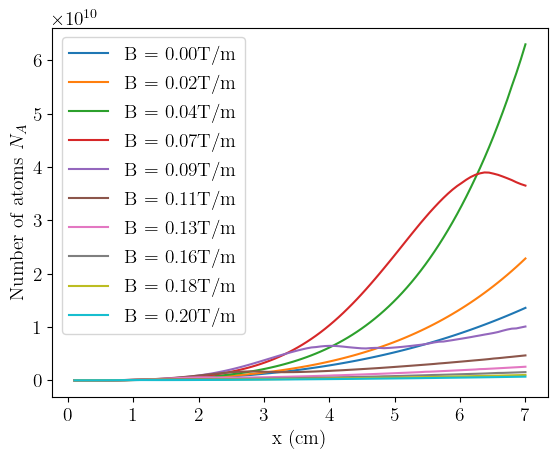

In [21]:
for j in range(10):
    plt.plot(beam_diam*100, rr[:,j],label= f'B = {mags[j]:.2f}T/m')
    plt.xlabel("x (cm)")
    plt.ylabel(r"$v_c$ (m/s)")
    plt.xlabel("x (cm)")
    plt.ylabel(r"Number of atoms $N_A$")
    plt.legend()
plt.savefig('Figures/noatoms_B.pdf', format='pdf')
#plt.xlim(0, 2)

Optimization Code 

In [22]:
def NA(parameters):
    x_0,beam_intensity, detuning, B = parameters
    v_0 = 0.1
    S_0 = (x_0, v_0)
    t = np.linspace(1, 0, 1000000) #was 1 and 0.2 adn 0.03 before
    t_span=[t[0], t[-1]]
    sol = sp.integrate.solve_ivp(dadt, t_span, S_0, t_eval = t, args=(beam_intensity, detuning*2*np.pi, B), method='RK23') # args = (beam_intensity, detuning, B)
    f_linear = sp.interpolate.interp1d(sol.y[0,:],sol.y[1,:])
    number_atoms = ((4*cons.pi*x_0**2)/(8*collision_cs)) * (f_linear(-x_0) / velocity_rms)**4
    return  np.array(number_atoms).item()
    #return [sol.y[0,:], sol.y[1,:]]

In [23]:
NA([0.01, 10, 8e6, 0])

129040362.49249196

In [24]:
first_guess = [0.01, 10, 8e6, 0] # [Beam diameter, Intensity, detuning, mag_field_gradient]
res = sp.optimize.minimize(lambda i: -NA(i), first_guess, bounds=[(0.01, 0.01), (10, 10), (8e6, 8e6), (0, 1)])


In [25]:
first_guess = [0.025, 10, 8e6, 0.9] # [Beam diameter, Intensity, detuning, mag_field_gradient]
res = sp.optimize.minimize(lambda i: -NA(i), first_guess, bounds=[(0.025, 0.05), (1, 20), (8e6, 15e6), (0, 3)])

In [26]:
res.x

array([5.00000000e-02, 2.00000000e+01, 8.00138948e+06, 5.64132837e-02])

In [27]:
NA(res.x)

91747550160.35477

In [28]:
"{:e}".format(NA(res.x))

'9.174755e+10'

In [29]:
first_guess = [0.01, 10, 8e6, 0] # [Beam diameter, Intensity, detuning, mag_field_gradient]
res = sp.optimize.minimize(lambda i: -NA(i), first_guess, bounds=[(0.01, 0.01), (10, 10), (8e6, 8e6), (0, 1)])

In [30]:
# Optimal Magnetic Gradient 
res.x

array([1.0000000e-02, 1.0000000e+01, 8.0000000e+06, 1.1787595e-01])

In [31]:
"{:e}".format(NA(res.x))

'2.615818e+08'

In [32]:
# Testing prediction
mag_test = np.linspace(0.01, 0.25, 100)
na_test_res = np.zeros_like(mag_test)

for i in range(len(mag_test)):
    na_test_res[i] = NA([0.01, 10, 8e6, mag_test[i]])


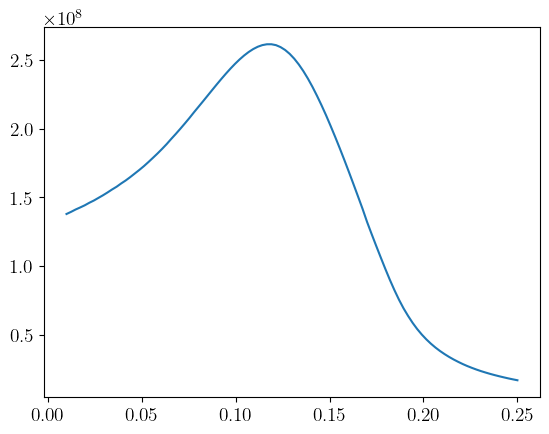

In [33]:
plt.plot(mag_test, na_test_res)

In [34]:
np.max(na_test_res)

261506361.60736498

In [35]:
test = sp.interpolate.interp1d(na_test_res, mag_test)
test(np.max(na_test_res))
#Checks out! 

array(0.11909091)